In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [2]:
tf.random.set_seed(74)

In [3]:
df = pd.read_csv('/kaggle/input/case-ih-time-series-data/data.csv', index_col=['date'], parse_dates=['date'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2021-09-30 to 2022-07-08
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   work    192 non-null    int64
 1   income  192 non-null    int64
dtypes: int64(2)
memory usage: 4.5 KB


In [5]:
df.columns 

Index(['work', 'income'], dtype='object')

In [6]:
df.head()

,work,income
date,,
2021-09-30,2,2100
2021-10-03,1,3600
2021-10-04,1,4000
2021-10-05,1,7900
2021-10-06,1,7500


In [7]:
df = df.drop(columns=['work'])

In [8]:
df.columns 

Index(['income'], dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2021-09-30 to 2022-07-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   income  192 non-null    int64
dtypes: int64(1)
memory usage: 3.0 KB


In [10]:
train_size = int(len(df)*0.75)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [11]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.fit_transform(test_data)

In [12]:
LOOK_BACK = 30

In [13]:
def create_dataset (X, look_back = 1):
    
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)

In [14]:
x_train, y_train = create_dataset(train_scaled,LOOK_BACK)
x_test, y_test = create_dataset(test_scaled,LOOK_BACK)

In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(114, 30, 1)
(114, 1)
(18, 30, 1)
(18, 1)


In [16]:
def create_bilstm(units):
    
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(x_train.shape[1], x_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    
    return model

In [17]:
model_bilstm = create_bilstm(64)

2023-02-06 12:24:22.721975: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
model_bilstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 30, 128)           33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 132,737
Trainable params: 132,737
Non-trainable params: 0
_________________________________________________________________


In [19]:
def create_gru(units):
    
    model = Sequential()
    
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(Dropout(0.2)) 
    
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    
    #Compile model
    model.compile(optimizer='adam', loss='mse')
    
    return model


In [20]:
model_gru = create_gru(64)

In [21]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 64)            12864     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


In [22]:
def fit_model(model):
    
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_los',patience = 10)
    
    history = model.fit(x_train, 
                        y_train, 
                        epochs = 200,  
                        validation_split = 0.2,
                        batch_size = 1, 
                        shuffle = False, 
                        callbacks = [early_stop])
    return history

In [23]:
history_bilstm = fit_model(model_bilstm)

Epoch 1/200


2023-02-06 12:24:24.512111: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


91/91 [==============================] - 9s 36ms/step - loss: 0.9418 - val_loss: 0.8305
Epoch 2/200
91/91 [==============================] - 2s 27ms/step - loss: 0.8978 - val_loss: 0.8877
Epoch 3/200
91/91 [==============================] - 2s 20ms/step - loss: 0.8762 - val_loss: 1.2097
Epoch 4/200
91/91 [==============================] - 2s 21ms/step - loss: 0.8605 - val_loss: 1.1655
Epoch 5/200
91/91 [==============================] - 2s 20ms/step - loss: 0.8529 - val_loss: 1.3061
Epoch 6/200
91/91 [==============================] - 2s 20ms/step - loss: 0.8291 - val_loss: 1.7897
Epoch 7/200
91/91 [==============================] - 2s 20ms/step - loss: 0.8011 - val_loss: 2.0060
Epoch 8/200
91/91 [==============================] - 2s 20ms/step - loss: 0.7911 - val_loss: 2.2957
Epoch 9/200
91/91 [==============================] - 2s 20ms/step - loss: 0.7740 - val_loss: 2.4405
Epoch 10/200
91/91 [==============================] - 2s 21ms/step - loss: 0.7568 - val_loss: 2.9531
Epoch 11/20

In [24]:
history_gru = fit_model(model_gru)

Epoch 1/200
91/91 [==============================] - 6s 30ms/step - loss: 0.9837 - val_loss: 0.7733
Epoch 2/200
91/91 [==============================] - 2s 21ms/step - loss: 0.9668 - val_loss: 0.7674
Epoch 3/200
91/91 [==============================] - 2s 22ms/step - loss: 0.9676 - val_loss: 0.7709
Epoch 4/200
91/91 [==============================] - 2s 21ms/step - loss: 0.9374 - val_loss: 0.7698
Epoch 5/200
91/91 [==============================] - 2s 21ms/step - loss: 0.9280 - val_loss: 0.7739
Epoch 6/200
91/91 [==============================] - 2s 21ms/step - loss: 0.9216 - val_loss: 0.7743
Epoch 7/200
91/91 [==============================] - 2s 21ms/step - loss: 0.9276 - val_loss: 0.7686
Epoch 8/200
91/91 [==============================] - 2s 20ms/step - loss: 0.9268 - val_loss: 0.7752
Epoch 9/200
91/91 [==============================] - 2s 21ms/step - loss: 0.9240 - val_loss: 0.7813
Epoch 10/200
91/91 [==============================] - 2s 20ms/step - loss: 0.9395 - val_loss: 0.7875

In [25]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [26]:
def plot_loss (history, model_name):
    
    plt.figure(figsize = (10, 6))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    
    plt.title('Model Train vs Validation Loss for ' + model_name)
    
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

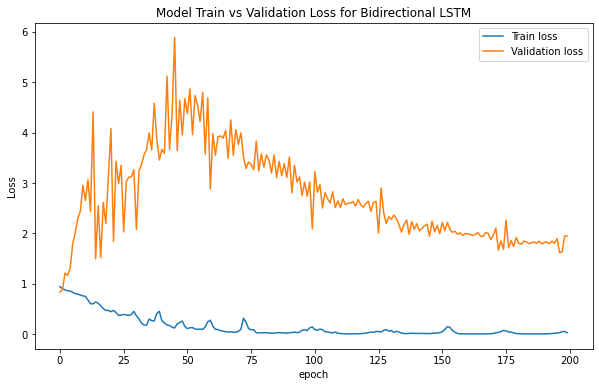

In [27]:
plot_loss(history_bilstm, 'Bidirectional LSTM')

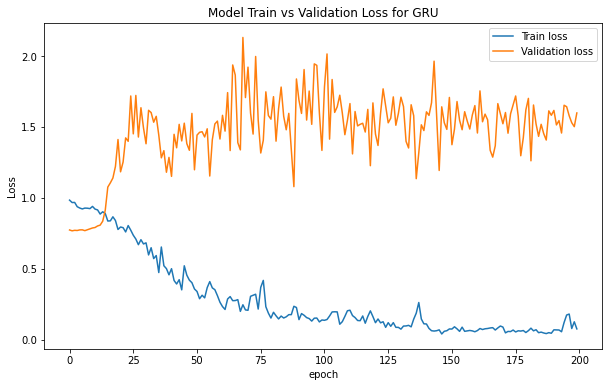

In [28]:
plot_loss(history_gru, 'GRU')

In [29]:
def prediction(model):
    
    prediction = model.predict(x_test)
    prediction = scaler.inverse_transform(prediction)
    
    return prediction

In [30]:
prediction_bilstm = prediction(model_bilstm)

In [31]:
prediction_gru = prediction(model_gru)

In [32]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    
    plt.plot(np.arange(range_future), np.array(y_test), label='Test   data')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    
    plt.title('Test data vs prediction for '+ model_name)
    
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('income')

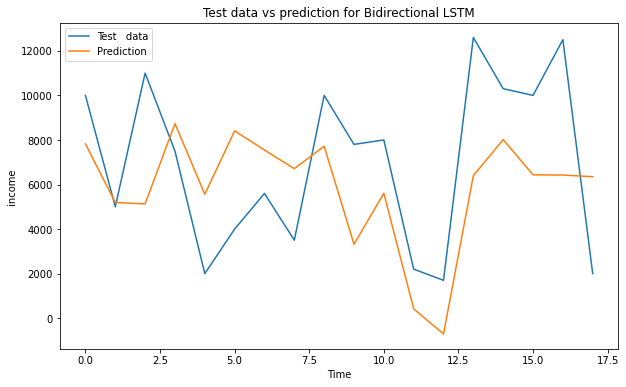

In [33]:
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

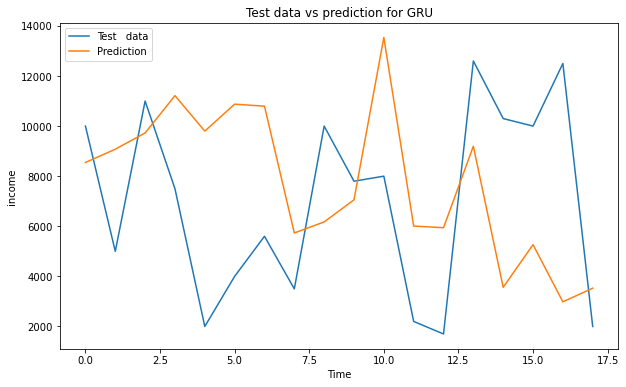

In [34]:
plot_future(prediction_gru, 'GRU', y_test)

In [35]:
def evaluate_prediction(predictions, actual, model_name):
    
    errors = predictions - actual
    
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

In [36]:
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

Bidirectiona LSTM:
Mean Absolute Error: 3246.2918
Root Mean Square Error: 3645.5331



In [37]:
evaluate_prediction(prediction_gru, y_test, 'GRU')

GRU:
Mean Absolute Error: 4261.1865
Root Mean Square Error: 4858.5181

